In [1]:
import os
import random
import re
import string

import nltk
import numpy as np
import pandas as pd

from gensim.models import Word2Vec

from nltk import word_tokenize
from nltk.corpus import stopwords

from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score

nltk.download("stopwords")
nltk.download("punkt")

SEED = 42
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
def clean_text(text, tokenizer, stopwords):
    """Pre-process text and generate tokens

    Args:
        text: Text to tokenize.

    Returns:
        Tokenized text.
    """
    text = str(text).lower()  # Lowercase words
    text = re.sub(r"\[(.*?)\]", "", text)  # Remove [+XYZ chars] in content
    text = re.sub(r"\s+", " ", text)  # Remove multiple spaces in content
    text = re.sub(r"\w+…|…", "", text)  # Remove ellipsis (and last word)
    text = re.sub(r"(?<=\w)-(?=\w)", " ", text)  # Replace dash between words
    text = re.sub(
        f"[{re.escape(string.punctuation)}]", "", text
    )  # Remove punctuation

    tokens = tokenizer(text)  # Get tokens from text
    tokens = [t for t in tokens if not t in stopwords]  # Remove stopwords
    tokens = ["" if t.isdigit() else t for t in tokens]  # Remove digits
    tokens = [t for t in tokens if len(t) > 1]  # Remove short tokens
    return tokens


custom_stopwords = set(stopwords.words("english"))
text_columns = ["text"]

df_raw = pd.read_csv("/kaggle/input/TSABTAE/train1.csv")
df = df_raw.copy()
#df["content"] = df["content"].fillna("")

for col in text_columns:
    df[col] = df[col].astype(str)

# Create text column based on title, description, and content
df["text"] = df[text_columns].apply(lambda x: " | ".join(x), axis=1)
df["tokens"] = df["text"].map(lambda x: clean_text(x, word_tokenize, custom_stopwords))

# Remove duplicated after preprocessing
_, idx = np.unique(df["tokens"], return_index=True)
df = df.iloc[idx, :]

# Remove empty values and keep relevant columns
df = df.loc[df.tokens.map(lambda x: len(x) > 0), ["text", "tokens"]]

docs = df["text"].values
tokenized_docs = df["tokens"].values

print(f"Original dataframe: {df_raw.shape}")
print(f"Pre-processed dataframe: {df.shape}")

In [3]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
#from tensorflow import keras
#import keras
#from keras.preprocessing.text import Tokenizer

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [4]:
# DATASET
DATASET_COLUMNS = ["target", "id", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [5]:
#dataset_filename = os.listdir("/kaggle/input/TSABTAE/train1.csv")[0]
#dataset_path = os.path.join("..","/kaggle/input/TSABTAE/",dataset_filename)
#print("Open file:", dataset_path)
df = pd.read_csv('/kaggle/input/TSABTAE/train1.csv')
#train_data= pd.read_csv("/kaggle/input/TSABTAE/train1.csv")#, delimiter ='\t')
test_data= pd.read_csv("/kaggle/input/TSABTAE/test1.csv",)

In [6]:
print("Dataset size:", len(df))

Dataset size: 1023999


In [7]:
decode_map = {0: "NEGATIVE", 1: "positive"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [8]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 421 ms, sys: 14.7 ms, total: 436 ms
Wall time: 441 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

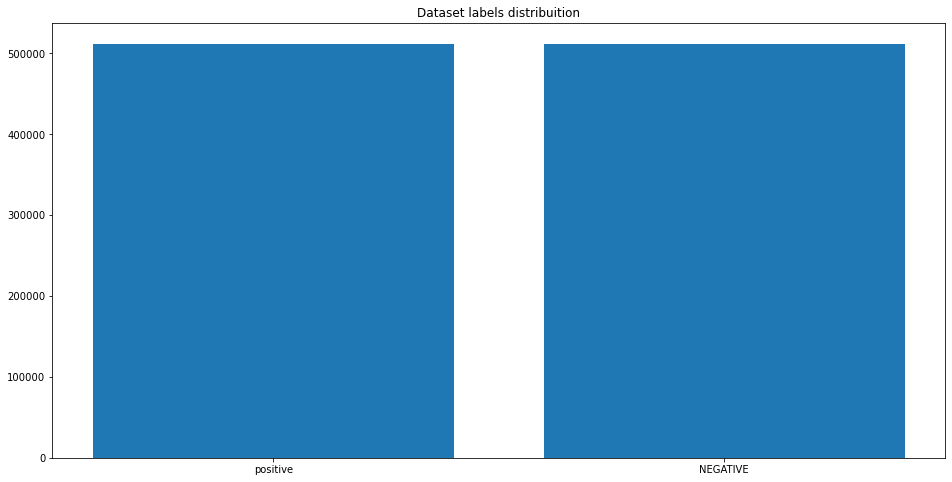

In [9]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [10]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 819199
TEST size: 204800


In [11]:
w2v_model = gensim.models.word2vec.Word2Vec(#size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [12]:
documents = [_text.split() for _text in df_train.text] 

In [13]:
w2v_model.build_vocab(documents)

In [14]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 439136


In [15]:
from keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

In [16]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['positive', 'NEGATIVE', 'NEUTRAL']

In [17]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (819199, 1)
y_test (204800, 1)


In [18]:
#model = Word2Vec(sentences=tokenized_docs, vector_size=100, workers=1, seed=SEED)


Note: In many cases, you might want to use a pre-trained model instead of training one yourself. If that's the case, gensim provides you with an easy way to access some of the most popular pre-trained word embeddings.
You can load a pre-trained Word2Vec model as follows:


In [19]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['positive', 'NEGATIVE', 'NEUTRAL']

In [20]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (819199, 1)
y_test (204800, 1)


In [21]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (819199, 300)
y_train (819199, 1)

x_test (204800, 300)
y_test (204800, 1)


embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

In [22]:
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

#data = list(zip(X_train,  y_train))
#kmeans = KMeans(n_clusters=2)
kmeans = KMeans(n_clusters=2, random_state=0, )#n_init="auto")#.fit(X_train)
kmeans.fit(x_train)#  y_train)#data)
kmeans.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [23]:
identified_clusters = kmeans.fit_predict(x_test)
identified_clusters

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [24]:
from sklearn.metrics import confusion_matrix,classification_report
print("ConfusionMatrix",confusion_matrix(y_test,identified_clusters))
print(classification_report(y_test,identified_clusters))

ConfusionMatrix [[100926    881]
 [101871   1122]]
              precision    recall  f1-score   support

           0       0.50      0.99      0.66    101807
           1       0.56      0.01      0.02    102993

    accuracy                           0.50    204800
   macro avg       0.53      0.50      0.34    204800
weighted avg       0.53      0.50      0.34    204800



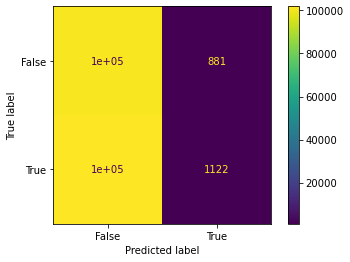

In [25]:
import matplotlib.pyplot as plt
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test,identified_clusters)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

Test

In [26]:
tokenizer.fit_on_texts(test_data.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 528557


In [27]:
x_orgionaltest = pad_sequences(tokenizer.texts_to_sequences(test_data.text), maxlen=SEQUENCE_LENGTH)

In [28]:
identified_clusters = kmeans.fit_predict(x_orgionaltest)
identified_clusters

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [29]:
submission = pd.DataFrame(data = {'id': test_data.id, 'target': identified_clusters})
submission.to_csv('Word2vec&KerasToken_Kmeanclusters1.csv', index = False)
submission.head()

,id,target
0,1136227,0
1,738556,0
2,1289784,0
3,1419520,1
4,1178091,0


# MiniBatch 

In [30]:
from sklearn.cluster import MiniBatchKMeans
MiniBatchkmeans = MiniBatchKMeans(n_clusters=2,
                          random_state=0,
                          batch_size=10000,#100
                          ).fit(x_train)

In [31]:
pred=MiniBatchkmeans.fit_predict(x_test)


In [32]:
from sklearn.metrics import confusion_matrix,classification_report
print("ConfusionMatrix",confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))

ConfusionMatrix [[  1745 100062]
 [  2306 100687]]
              precision    recall  f1-score   support

           0       0.43      0.02      0.03    101807
           1       0.50      0.98      0.66    102993

    accuracy                           0.50    204800
   macro avg       0.47      0.50      0.35    204800
weighted avg       0.47      0.50      0.35    204800



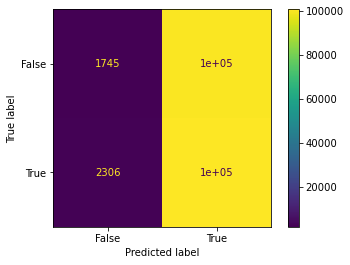

In [33]:
confusion_matrix = metrics.confusion_matrix(y_test,pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

word_vectors = model.wv #load the vectors from the model


def vectorize(list_of_docs, model):
    """Generate vectors for list of documents using a Word Embedding

    Args:
        list_of_docs: List of documents
        model: Gensim's Word Embedding

    Returns:
        List of document vectors
    """
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features
    
vectorized_docs = vectorize(tokenized_docs, model=model)
len(vectorized_docs), len(vectorized_docs[0])

In [34]:
#vectorized_docs

This function creates the clusters using the Mini-batches K-means algorithm. It takes the following arguments:

X: Matrix of features. In this case, it's your vectorized documents.
k: Number of clusters you'd like to create.
mb: Size of mini-batches.
print_silhouette_values: Defines if the Silhouette Coefficient is printed for each cluster. If you haven't heard about this coefficient, don't worry, you'll learn about it in a bit!
mbkmeans_cluster takes these arguments and returns the fitted clustering model and the labels for each document.

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
# read data 
train_data= pd.read_csv("/kaggle/input/TSABTAE/train1.csv")#, delimiter ='\t')
test_data= pd.read_csv("/kaggle/input/TSABTAE/test1.csv",)# delimiter ='\t')

In [35]:
#y=train_data['target']

In [36]:
#y= 

In [37]:
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test= train_test_split(vectorized_docs,y, test_size=0.2, random_state=0)

from sklearn.cluster import KMeans

#data = list(zip(X_train,  y_train))
#kmeans = KMeans(n_clusters=2)
kmeans = KMeans(n_clusters=2, random_state=0, )#n_init="auto")#.fit(X_train)
#kmeans.fit(import numpy as np 
#  y_train)#data)
#kmeans.labels_x_train

identified_clusters = kmeans.fit_predict(vectorized_docs)
identified_clusters

from sklearn.metrics import confusion_matrix,classification_report
print("ConfusionMatrix",confusion_matrix(y_test,identified_clusters))
print(classification_report(y_test,identified_clusters))

def mbkmeans_clusters(
	X, 
    k, 
    mb, 
    print_silhouette_values, 
):
    """Generate clusters and print Silhouette metrics using MBKmeans

    Args:
        X: Matrix of features.
        k: Number of clusters.
        mb: Size of mini-batches.
        print_silhouette_values: Print silhouette values per cluster.

    Returns:
        Trained clustering model and labels based on X.
    """
    km = MiniBatchKMeans(n_clusters=k, batch_size=mb).fit(X)
    print(f"For n_clusters = {k}")
    print(f"Silhouette coefficient: {silhouette_score(X, km.labels_):0.2f}")
    print(f"Inertia:{km.inertia_}")

    if print_silhouette_values:
        sample_silhouette_values = silhouette_samples(X, km.labels_)
        print(f"Silhouette values:")
        silhouette_values = []
        for i in range(k):
            cluster_silhouette_values = sample_silhouette_values[km.labels_ == i]
            silhouette_values.append(
                (
                    i,
                    cluster_silhouette_values.shape[0],
                    cluster_silhouette_values.mean(),
                    cluster_silhouette_values.min(),
                    cluster_silhouette_values.max(),
                )
            )
        silhouette_values = sorted(
            silhouette_values, key=lambda tup: tup[2], reverse=True
        )
        for s in silhouette_values:
            print(
                f"    Cluster {s[0]}: Size:{s[1]} | Avg:{s[2]:.2f} | Min:{s[3]:.2f} | Max: {s[4]:.2f}"
            )
    return km, km.labels_

clustering, cluster_labels = mbkmeans_clusters(
	X=vectorized_docs,
    k=2,# of clusters
    mb=500,
    print_silhouette_values=True,
)
df_clusters = pd.DataFrame({
    "text": docs,
    "tokens": [" ".join(text) for text in tokenized_docs],
    "cluster": cluster_labels
})

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session